In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from nfact_id.functions.questionnaire_scoring import (
    pdc_get_timepoint_1,
    process_questionnaire,
    questionnaire_transform_merge
    )
from nfact_id.functions.behavioural_functions import (
    convert_df_type,
    merge_dataframes,
    scaled_data,
    impute_group_median,


)
import numpy as np
from nfact_id.functions.factor_analysis import data_fit, create_loading_design_matrix, model_fit_parameters, cfa_model, obtain_correlation_values
import seaborn as sns
sns.set_style('dark')
from data_dictionaries_for_subjects import banda_questions, ep_questions, pdc_questions, get_columns_from_dictionary, score_rcads
del(ep_questions['psychosis'])
del(banda_questions['psychosis'])
from factor_analyzer import FactorAnalyzer
from decouple import config
import os

In [2]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')

In [3]:
def iterative_pruning(df, n_factors=3, loading_thresh=0.3, communal_thresh=0.3):
    items_to_keep = df.columns.tolist()
    iteration = 1
    
    while True:
        print(f"\nIteration {iteration}, {len(items_to_keep)} items remaining")
        
        # Run factor analysis
        
        fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
        fa.fit(df[items_to_keep])
        
        loadings = pd.DataFrame(fa.loadings_, index=items_to_keep)
        communalities = pd.Series(fa.get_communalities(), index=items_to_keep)
        
        # Identify items to drop
        low_loading_items = loadings.apply(lambda x: x.abs().max() < loading_thresh, axis=1)
        low_communality_items = communalities < communal_thresh
        items_to_drop = low_loading_items | low_communality_items 
        
        if items_to_drop.sum() == 0:
            print("No more items to drop. Pruning complete.")
            break
        
        print(f"Dropping {items_to_drop.sum()} items: {list(items_to_drop[items_to_drop].index)}")
        items_to_keep = [item for item in items_to_keep if item not in list(items_to_drop[items_to_drop].index)]
        iteration += 1

    return items_to_keep


## PDC

### Get and clean pdc data

In [4]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace('HEALTHY', '').str.lstrip()
pdc_key['src_subject_id'] = pdc_key['src_subject_id'].str.lstrip()
pdc_particpant_info = pdc_key.rename(columns={"src_subject_id": "id"})
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)
pdc_df_keys = get_columns_from_dictionary(pdc_questions)

### Get and clean questionnaires

In [5]:
cols_to_drop = ['collection_id', 'dataset_id', 'interview_date', 'interview_age', 'src_subject_id', 'sex', 'subjectkey', 'collection_title', 'src_subject_id_mod', 'Study']

In [6]:
apath_pdc = pdc_get_timepoint_1(pdc_df['apath01'], pdc_particpant_info).drop(columns=cols_to_drop)
shaps_pdc = pdc_get_timepoint_1(pdc_df['shaps01'], pdc_particpant_info).drop(columns=cols_to_drop)
hrsd_pdc = pdc_get_timepoint_1(pdc_df['hrsd01'], pdc_particpant_info).drop(columns=cols_to_drop)
bids_pdc = pdc_get_timepoint_1(pdc_df['bisbas01'], pdc_particpant_info).drop(columns=cols_to_drop)
bids_pdc = bids_pdc.replace('999', np.nan) 
qids_pdc = pdc_get_timepoint_1(pdc_df['qids01'], pdc_particpant_info).drop(columns=cols_to_drop)
dass_pdc = pdc_get_timepoint_1(pdc_df['dass01'], pdc_particpant_info).drop(columns=cols_to_drop)
dass_pdc = dass_pdc.replace('999', np.nan)
apath_pdc = apath_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_pdc = shaps_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
hrsd_pdc = hrsd_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
bids_pdc = bids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
qids_pdc = qids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
dass_pdc = dass_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1).drop("dass_anx_sc", axis=1)
pdc_scores = merge_dataframes([
    apath_pdc,
    shaps_pdc,
    hrsd_pdc, 
    bids_pdc, 
    qids_pdc, 
    dass_pdc,
    pdc_particpant_info[['id', 'phenotype']]
    ]).sort_values(by="phenotype")

### Create a loadings dictionary by key and factor type

In [7]:
pdc_loadings_dict = {}
pdc_items = iterative_pruning(pdc_scores.select_dtypes(include=['number']).dropna(axis=1))
for phenotype in pdc_questions.keys():
    pdc_loadings_dict[phenotype] =  list({key for subdict in pdc_questions[phenotype].values() for key in subdict if key in pdc_items})
pdc_columns = pdc_loadings_dict['anxiety'] + pdc_loadings_dict['depression']
del pdc_loadings_dict['psychosis']
pdc_loadings_dict['interanlising'] = pdc_columns


Iteration 1, 115 items remaining
Dropping 37 items: ['apath_10', 'apath_12', 'apath_13', 'apath_17', 'hsoin', 'hmnin', 'hemin', 'hinsg', 'happt', 'hwl', 'hhypc', 'hsuic', 'hslow', 'hagit', 'bisbas1', 'bisbas2', 'bisbas6', 'bisbas8', 'bisbas10', 'bisbas11', 'bisbas13', 'bisbas15', 'bisbas17', 'bisbas18', 'bisbas19', 'bisbas20', 'bisbas21', 'bisbas22', 'bisbas23', 'bisbas24', 'vsoin', 'vmnin', 'vemin', 'vhysm', 'vapdc', 'dass_2', 'dass_4']

Iteration 2, 78 items remaining
Dropping 1 items: ['vsuic']

Iteration 3, 77 items remaining
No more items to drop. Pruning complete.


## Check if individual elements are appriopriate for factor analaysis

In [8]:
pdc_data_for_factor = pdc_scores[pdc_columns]

In [9]:
pdc_data_fit = data_fit(pdc_data_for_factor) 
print(pdc_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = pdc_data_fit['kmo_all'].where(pdc_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', pdc_data_fit['kmo_model'])
print('\nbartlett pval', pdc_data_fit['bartlett_pval'])
print('\nbart chi2',pdc_data_fit['bartlett_chi2'])

       KMO Score
count  47.000000
mean    0.938333
std     0.017979
min     0.891658
25%     0.928806
50%     0.940573
75%     0.949210
max     0.972335

factors possibly not suitable: 
Series([], dtype: float64)

model kmo 0.9405728042135445

bartlett pval 0.0

bart chi2 9271.38637614975


In [10]:
obtain_correlation_values(pdc_scores[pdc_columns], 0.85)

apath_07  apath_18    0.865115
shaps12   shaps6      0.867655
shaps11   shaps12     0.889277
dtype: float64

### Scale Data and create design matrix

### Fit model and inspect

In [15]:
pdc_matrix = create_loading_design_matrix(pdc_loadings_dict, pdc_columns)
pdc_scaled = pd.DataFrame(scaled_data(pdc_scores[pdc_columns]))


In [16]:
pdc_model = cfa_model(pdc_matrix, pdc_scaled, len(pdc_loadings_dict.keys()), len(pdc_columns), [key for key in pdc_loadings_dict.keys()])
fit = model_fit_parameters(pdc_model, pdc_scaled, cols=pdc_columns)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression'})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,hpanx,dass_19,dass_14,hsanx,dass_1,dass_9,dass_15,dass_20,dass_11,dass_12,...,apath_15,apath_18,apath_05,shaps1,shaps11,shaps8,shaps2,shaps10,shaps9,shaps6
depression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.903019,0.566324,0.564956,1.431392,1.395051,1.459591,1.404343,1.355678,1.279229,1.309325
anxiety,1.045248,0.921211,0.910803,0.844618,1.053202,1.028660,1.001314,0.931534,1.091355,1.177812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.627038,1.133900,0.916277,0.635077,0.846477,1.109284,1.118813,1.010539,1.025806,0.963795,...,0.868202,1.164256,1.291314,0.773507,1.260305,0.945626,0.994427,0.845216,1.086823,1.118307


'rmse 1.22164273687922'

'mse 1.7243959695968882'

## Run this cell after running the model then re run the model

In [13]:
negative_items = [item for item in pdc_loadings_dict["depression"] if loading_df.loc["depression", item] < 0]
negative_items_dep = [item for item in pdc_loadings_dict["anxiety"] if loading_df.loc["anxiety", item] < 0]
# Step 2: Remove them from Depression
pdc_loadings_dict["depression"] = [item for item in pdc_loadings_dict["depression"] if item not in negative_items]
pdc_loadings_dict["anxiety"] = [item for item in pdc_loadings_dict["anxiety"] if item not in negative_items_dep]
# Step 3: Add them to Anxiety
pdc_loadings_dict["anxiety"].extend(negative_items)
pdc_loadings_dict["depression"].extend(negative_items)
print("Updated loading dictionary:")
print(pdc_loadings_dict)


Updated loading dictionary:
{'depression': ['shaps13', 'shaps5', 'apath_09', 'shaps4', 'apath_03', 'vslow', 'apath_08', 'shaps3', 'apath_16', 'apath_06', 'apath_07', 'apath_01', 'shaps12', 'apath_04', 'shaps7', 'shaps14', 'apath_11', 'apath_14', 'apath_02', 'apath_15', 'apath_18', 'apath_05', 'shaps1', 'shaps11', 'shaps8', 'shaps2', 'shaps10', 'shaps9', 'shaps6', 'hengy', 'vengy', 'hmdsd', 'vmdsd'], 'anxiety': ['hpanx', 'dass_19', 'dass_14', 'hsanx', 'dass_1', 'dass_9', 'dass_15', 'dass_20', 'dass_11', 'dass_12', 'dass_6', 'dass_7', 'vagit', 'dass_8', 'hengy', 'vengy', 'hmdsd', 'vmdsd'], 'interanlising': ['hpanx', 'dass_19', 'dass_14', 'hsanx', 'dass_1', 'dass_9', 'dass_15', 'dass_20', 'dass_11', 'dass_12', 'dass_6', 'dass_7', 'vagit', 'dass_8', 'shaps13', 'shaps5', 'hengy', 'apath_09', 'shaps4', 'apath_03', 'vslow', 'apath_08', 'shaps3', 'vengy', 'hmdsd', 'apath_16', 'apath_06', 'apath_07', 'apath_01', 'shaps12', 'apath_04', 'shaps7', 'shaps14', 'apath_11', 'vmdsd', 'apath_14', 'apath

In [17]:
det_corr = np.linalg.det(np.corrcoef(pdc_scaled, rowvar=False))
print(f"Determinant of correlation matrix: {det_corr}")  

Determinant of correlation matrix: 5.191646029737291e-21


In [18]:
pdc_data = pd.concat([pdc_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].sort_values(by="phenotype").reset_index(drop=True), 
                        pd.DataFrame(pdc_model.fit_transform(pdc_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Internalizing"})], axis=1)

In [19]:
pdc_data['phenotype'] = pdc_data['phenotype'].apply(lambda x: 'Control' if x =='Control' else "T_depression")
# Because internalising is negatively correlated to depression/anxiety its sign can be flipped
pdc_data['Internalizing'] = pdc_data['Internalizing'] * -1

In [20]:
pdc_data.groupby("phenotype").mean(numeric_only=True)

,Anxiety,Depression,Internalizing
phenotype,,,
Control,-0.304784,-1.489615,-0.791066
T_depression,0.091802,0.448679,0.238273


In [21]:
pdc_data[['Anxiety', 'Depression', "Internalizing"]].corr()

,Anxiety,Depression,Internalizing
Anxiety,1.000000,0.230063,0.476867
Depression,0.230063,1.000000,0.773358
Internalizing,0.476867,0.773358,1.000000


<Axes: >

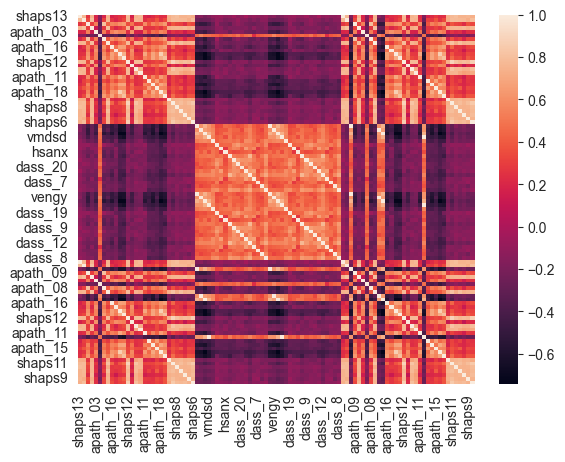

In [22]:
col_used = [item for sublist in pdc_loadings_dict.values() for item in sublist]
sns.heatmap(pdc_scores[col_used].corr())  

## EP

In [23]:
def get_ep_data(df, participant_info):
    df['src_subject_id'] = df['src_subject_id'].astype("int64")
    return pd.merge(df, participant_info[['id', 'phenotype']], 
                    left_on='src_subject_id', 
                    right_on='id', 
                    how='right').drop('src_subject_id', axis=1)

In [24]:
ep_df = pd.read_excel(os.path.join(base_dir, 'EP', 'BehaviouralFiles.xlsx'), sheet_name=None)
ep_key = pd.read_csv(os.path.join(base_dir, 'EP', 'tmp', 'EPinfocomplete.csv'))
ep_key_part = pd.read_csv("sub_ids/ep_id.csv")
ep_key = ep_key[['imgkey', 'interview_age',	'sex', 'phenotype']]
ep_key['imgkey'] = ep_key['imgkey'].str.replace('_01_MR', '').str.lstrip().astype("int")
ep_key['phenotype'] = ep_key['phenotype'].str.replace('Patient', 'early_psychosis').str.lstrip()
ep_key = ep_key.rename(columns={'imgkey': 'id'})
ep_particpant_info = pd.merge(left=ep_key, right=ep_key_part, left_on='id', right_on='part',  how='right').drop('part', axis=1)
ep_particpant_info = ep_particpant_info[ep_particpant_info['phenotype'] != 'Control']

In [25]:
ep_df_keys = get_columns_from_dictionary(ep_questions)
edd_rs = get_ep_data(ep_df['predd01'][1:], ep_particpant_info)[['id', 'phenotype', 'edd_rs']]
panns_ep = get_ep_data(ep_df['panss01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['panss01']]
yms_ep = get_ep_data(ep_df['ymrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['ymrs01']]
madrs_ep = get_ep_data(ep_df['madrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['madrs01']]
preda_ep = get_ep_data(ep_df['preda01'][1:][['src_subject_id', 'anx_rs'] + ep_df_keys['preda01']].dropna(), ep_particpant_info)[['id', 'phenotype', 'anx_rs']]
edd_rs = edd_rs.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
panns_ep = panns_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
yms_ep = yms_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
madrs_ep = madrs_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
preda_ep = preda_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
ep_scores = merge_dataframes([
    yms_ep,
    panns_ep,
    madrs_ep, 
    edd_rs,
    preda_ep, 
    ep_particpant_info[['id', 'phenotype']]
    ])

In [34]:
ep_loadings_dict = {}
ep_questions['depression']['ymrs01'].extend("ymrstot")
ep_items = iterative_pruning(ep_scores.select_dtypes(include=['number']))
for phenotype in ep_questions.keys():
    ep_loadings_dict[phenotype] =  list({key for subdict in ep_questions[phenotype].values() for key in subdict if key in ep_items})
ep_loadings_dict['anxiety'].extend(["anx_rs"])
ep_loadings_dict['depression'].extend(["edd_rs"])
ep_columns = ep_loadings_dict['anxiety'] + ep_loadings_dict['depression']
ep_loadings_dict['internalising'] = ep_columns
# REpeated twice
ep_loadings_dict['depression'].remove("sleepamt")



Iteration 1, 25 items remaining
Dropping 10 items: ['id', 'sexinter', 'gps_g11', 'gps_g3', 'gps_g4', 'gps_g16', 'madrsapp', 'madrslas', 'edd_rs', 'anx_rs']

Iteration 2, 15 items remaining
Dropping 2 items: ['neg_n5', 'gps_g7']

Iteration 3, 13 items remaining
No more items to drop. Pruning complete.


In [35]:
ep_data_fit = data_fit(ep_scores[ep_columns]) #convert_df_type(ep_scores[ep_columns]))
print(ep_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = ep_data_fit['kmo_all'].where(ep_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', ep_data_fit['kmo_model'])
print('\nbartlett pval', ep_data_fit['bartlett_pval'])
print('\nbart chi2',ep_data_fit['bartlett_chi2'])

       KMO Score
count  16.000000
mean    0.735664
std     0.155712
min     0.514287
25%     0.581928
50%     0.808802
75%     0.866133
max     0.907284

factors possibly not suitable: 
sleepamt  KMO Score    0.514287
anx_rs    KMO Score    0.520178
neg_n4    KMO Score    0.553865
neg_n2    KMO Score    0.663939
sleepamt  KMO Score    0.514287
madrsslp  KMO Score    0.591282
edd_rs    KMO Score    0.658865
dtype: float64

model kmo 0.7496319442039229

bartlett pval 0.0

bart chi2 4204.13967042493


In [36]:
obtain_correlation_values(ep_scores[ep_columns], 0.8)

gps_g6  madrssad    0.817827
dtype: float64

In [37]:
ep_matrix = create_loading_design_matrix(ep_loadings_dict, ep_columns)

In [38]:
ep_scaled = scaled_data(ep_scores[ep_columns])
ep_model = cfa_model(ep_matrix, ep_scaled, len(ep_loadings_dict.keys()), len(ep_columns), [key for key in ep_loadings_dict.keys()])

In [39]:
det_corr = np.linalg.det(np.corrcoef(ep_scaled, rowvar=False))
print(f"Determinant of correlation matrix: {det_corr}")  

Determinant of correlation matrix: 2.4253807425179563e-18


In [40]:
fit = model_fit_parameters(ep_model, ep_scaled, cols=ep_columns)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression'})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,gps_g2,madrsten,sleepamt,anx_rs,neg_n4,gps_g6,madrspes,madrscon,madrsfee,madrsaps,neg_n2,sleepamt,madrsslp,madrssui,madrssad,edd_rs
depression,0.000000,0.000000,0.000000,0.000000,0.848923,1.233041,0.759125,0.747694,0.968855,1.070443,1.033541,0.0,0.37665,0.720149,1.134912,0.647111
anxiety,0.735281,0.696651,0.574673,0.542713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
2,1.122530,1.042577,0.695436,0.431717,0.330475,1.225647,1.414828,1.177066,0.853495,0.860132,0.424136,0.0,0.89738,0.966837,1.403863,0.590053


'rmse 0.19126623502663048'

'mse 0.04108833854326402'

In [41]:
ep_data = pd.concat([ep_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(ep_model.fit_transform(ep_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: 'Internalizing'
                                                                                          })], axis=1)

In [42]:
ep_data.groupby("phenotype").mean(numeric_only=True)[["Anxiety","Depression",'Internalizing']]


,Anxiety,Depression,Internalizing
phenotype,,,
early_psychosis,-7.601527e-17,-9.601929e-17,6.801366e-17


In [43]:
ep_data[['Anxiety', 'Depression', 'Internalizing']].corr()

,Anxiety,Depression,Internalizing
Anxiety,1.000000,0.734492,-0.76479
Depression,0.734492,1.000000,-0.75762
Internalizing,-0.764790,-0.757620,1.00000


<Axes: >

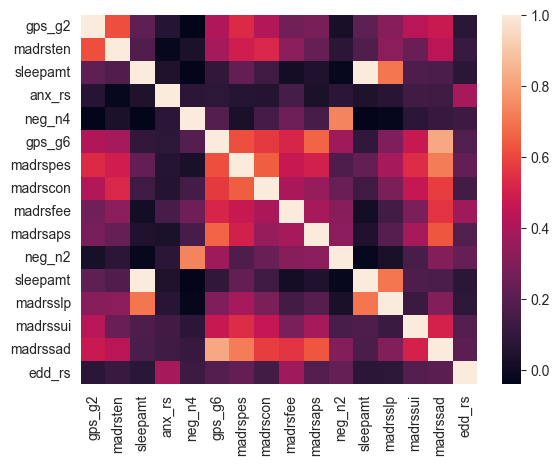

In [44]:
sns.heatmap(ep_scores[ep_columns].corr())  

## BANDA

In [45]:
banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [46]:
banda_df_keys = get_columns_from_dictionary(banda_questions)

In [47]:
state_cols = [col for col in banda_df["stai01"].columns if "Right now" in str(banda_df["stai01"].loc[0, col])]
trait_cols = [col for col in banda_df["stai01"].columns if "Generally" in str(banda_df["stai01"].loc[0, col])]

In [48]:
stai01 = banda_df["stai01"][banda_df["stai01"]['visit'] == 'T1']
stai01 = stai01.drop(stai01[stai01['src_subject_id'].duplicated()].index)
stai01 = pd.merge(stai01.drop(["collection_id", "stai01_id", "dataset_id", "subjectkey"], axis=1), band_particpant_info, left_on='src_subject_id', right_on='id')
stai01 = stai01.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)

In [49]:
transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = impute_group_median(group[state_cols])
    dataframe = pd.DataFrame(np.round(transformed))#.sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_state = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_state = stai01_state.rename(columns={"src_subject_id": "id", 0: "state_val"}).sort_values(by='id')

transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = impute_group_median(group[trait_cols])
    dataframe = pd.DataFrame(np.round(transformed))#.sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_trait = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_trait = stai01_trait.rename(columns={"src_subject_id": "id", 0: "trait_val"}).sort_values(by='id')

Anxiety
Control
Depression
Anxiety
Control
Depression


In [50]:
def score_rcads_2(rcads_data):
    rdacs_score = {"Never": 0, "Sometimes": 1, "Often": 2, "Always": 3}
    rcads01 = rcads_data[rcads_data["visit"] == "T1"]
    rcads01 = rcads01.drop(rcads01[rcads01["src_subject_id"].duplicated()].index)
    rcads_cols = rcads01.columns[8:]
    rcads01["src_subject_id"].loc[1:]
    scored_df = rcads01[rcads_cols].replace(rdacs_score)
    scored_df["particpant"] = rcads01["src_subject_id"].loc[1:]
    return scored_df
  

In [51]:
mfq_banda = questionnaire_transform_merge(banda_df["mfq01"], band_particpant_info, 'mfq01_id', "mfq_score", banda_df["mfq01"].columns[8: 41]).drop("phenotype", axis=1)
shaps_banda = questionnaire_transform_merge(banda_df["shaps01"], band_particpant_info, 'shaps01_id', "shaps_score", banda_df["shaps01"].columns[8: 22]).drop("phenotype", axis=1)
cbcl_banda = process_questionnaire(banda_df["cbcl01"], band_particpant_info, 'cbcl01_id')[['id', 'phenotype']+ banda_questions['depression']['cbcl01']].drop("phenotype", axis=1)
cssrs_banda = process_questionnaire(banda_df["cssrs01"], band_particpant_info, 'cssrs01_id')[['id', 'phenotype']+ banda_questions['depression']['cssrs01']].drop("phenotype", axis=1)
rcads_banda = score_rcads_2(banda_df['rcads01']).drop(["visit", "respondent", "collection_title", "Study"], axis=1)
bisbas_banda =  process_questionnaire(banda_df["bisbas01"], band_particpant_info, 'bisbas01_id')#[['id', 'phenotype']+ banda_questions['depression']['cbcl01']].drop("phenotype", axis=1)'bisbas01']

In [52]:
merged_df = merge_dataframes([
    rcads_banda.rename(columns={"particpant": "id"}),
    stai01_state.drop("phenotype", axis=1),
    stai01_trait.drop("phenotype", axis=1),
    shaps_banda,
    mfq_banda,
    cbcl_banda, cssrs_banda])
banda_df_scored = pd.merge(band_particpant_info, merged_df, how='outer')
banda_df_scored = banda_df_scored.replace("999", np.nan)
banda_df_scored[banda_df_scored.columns[4:]] = banda_df_scored[banda_df_scored.columns[4:]].applymap(lambda x: pd.to_numeric(x, errors='coerce') if pd.notna(x) else x)


In [53]:
banda_df_scored

,id,phenotype,sex,interview_age,rcads_1,rcads_2,rcads_3,rcads_4,rcads_5,rcads_6,...,sb6l,css_sim1,css_sim2,sbnssibp3m,sbsibiul,sbsibiup3m,sbiap3m,sbpabp3m,sbasiap3m,sb_present_interview_3m
0,BANDA001,Control,F,184,1.0,1.0,0.0,3.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
1,BANDA002,Control,F,169,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
2,BANDA003,Control,M,177,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
3,BANDA004,Control,M,188,1.0,1.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
4,BANDA005,Control,M,191,1.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,2.0,1.0,0.0,1.0,1.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
199,BANDA211,Depression,F,196,3.0,2.0,2.0,3.0,0.0,1.0,...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
200,BANDA212,Depression,F,186,3.0,3.0,1.0,2.0,2.0,1.0,...,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
201,BANDA213,Depression,F,184,3.0,2.0,1.0,3.0,1.0,2.0,...,NaN,1.0,0.0,2.0,NaN,1.0,2.0,2.0,2.0,NaN


In [54]:
grouping = banda_df_scored.groupby("phenotype")
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].mean(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']])

In [55]:
banda_df_scored

,id,phenotype,sex,interview_age,rcads_1,rcads_2,rcads_3,rcads_4,rcads_5,rcads_6,...,sb6l,css_sim1,css_sim2,sbnssibp3m,sbsibiul,sbsibiup3m,sbiap3m,sbpabp3m,sbasiap3m,sb_present_interview_3m
0,BANDA001,Control,F,184,1.0,1.0,0.0,3.0,0.0,0.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
1,BANDA002,Control,F,169,0.0,0.0,1.0,1.0,0.0,0.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
2,BANDA003,Control,M,177,0.0,0.0,0.0,1.0,0.0,0.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
3,BANDA004,Control,M,188,1.0,1.0,0.0,2.0,0.0,1.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
4,BANDA005,Control,M,191,1.0,1.0,0.0,0.0,0.0,0.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,BANDA205,Depression,F,192,3.0,2.0,0.0,3.0,0.0,3.0,...,1.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
195,BANDA206,Depression,F,192,2.0,2.0,1.0,3.0,2.0,1.0,...,2.000000,1.0,1.0,1.0,2.000000,2.0,2.0,2.0,2.0,0.000000
199,BANDA211,Depression,F,196,3.0,2.0,2.0,3.0,0.0,1.0,...,2.000000,0.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000
200,BANDA212,Depression,F,186,3.0,3.0,1.0,2.0,2.0,1.0,...,2.000000,1.0,0.0,2.0,2.000000,2.0,2.0,2.0,2.0,0.000000


In [56]:
banda_items = iterative_pruning(banda_df_scored.select_dtypes(include=['number']).drop("interview_age", axis=1))
banda_loadings = {}
for phenotype in banda_questions.keys():
    banda_loadings[phenotype] =  list({key for subdict in banda_questions[phenotype].values() for key in subdict if key in banda_items})
banda_columns = banda_loadings['anxiety'] + banda_loadings['depression']
banda_loadings['internalsing'] = banda_columns


Iteration 1, 111 items remaining
Dropping 28 items: ['rcads_5', 'rcads_9', 'rcads_17', 'rcads_31', 'rcads_38', 'rcads_42', 'rcads_44', 'rcads_46', 'stai_state18_i', 'stai_trait14_i', 'shaps_score', 'cbcl52', 'cbcl54', 'cbcl76', 'cbcl77', 'cbcl91', 'sb2l', 'sb3l', 'sb4l', 'sb5l', 'sb6l', 'sbnssibp3m', 'sbsibiul', 'sbsibiup3m', 'sbiap3m', 'sbpabp3m', 'sbasiap3m', 'sb_present_interview_3m']

Iteration 2, 83 items remaining
Dropping 2 items: ['rcads_16', 'css_sim2']

Iteration 3, 81 items remaining
No more items to drop. Pruning complete.


<Axes: >

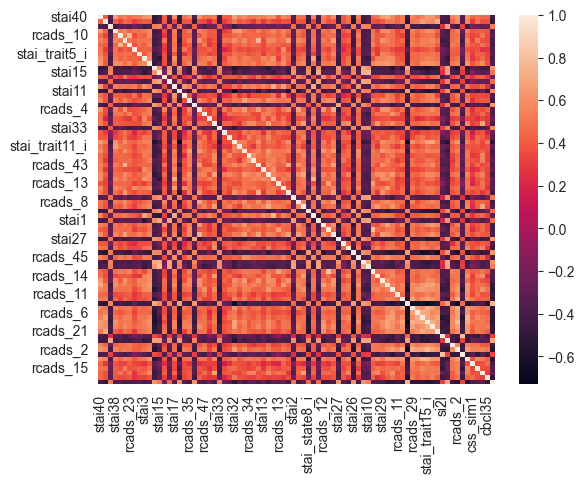

In [57]:
sns.heatmap(banda_df_scored[banda_columns].corr())  

In [58]:
banda_data_fit = data_fit(convert_df_type(banda_df_scored[banda_columns]))
print(banda_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = banda_data_fit['kmo_all'].where(banda_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', banda_data_fit['kmo_model'])
print('\nbartlett pval', banda_data_fit['bartlett_pval'])
print('\nbart chi2',banda_data_fit['bartlett_chi2'])

       KMO Score
count  80.000000
mean    0.940706
std     0.018071
min     0.889221
25%     0.929678
50%     0.943564
75%     0.954072
max     0.976843

factors possibly not suitable: 
Series([], dtype: float64)

model kmo 0.9428234237114285

bartlett pval 0.0

bart chi2 14612.568539748027


In [59]:
obtain_correlation_values(banda_df_scored[banda_columns], 0.8)

rcads_22  rcads_27    0.810011
si1l      si2l        0.801037
dtype: float64

In [60]:
banda_matrix = create_loading_design_matrix(banda_loadings, banda_columns)

In [61]:
banda_scaled = pd.DataFrame(scaled_data(banda_df_scored[banda_columns]), columns=banda_columns)
banda_model = cfa_model(banda_matrix, banda_scaled, len(banda_loadings.keys()), len(banda_columns), [key for key in banda_loadings.keys()])

In [62]:
det_corr = np.linalg.det(banda_scaled.corr())
print(f"Determinant of correlation matrix: {det_corr}")   

Determinant of correlation matrix: 4.288772873409614e-37


In [63]:
fit = model_fit_parameters(banda_model, banda_scaled, cols=banda_columns)
load_df = fit['loadings'].rename(index={0:"Depression", 1: "Anxiety"})
display(load_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,stai40,stai_trait2_i,stai_state19_i,stai38,rcads_10,rcads_20,rcads_23,stai_state4_i,stai_trait5_i,stai3,...,stai20,rcads_37,rcads_2,si1l,rcads_40,css_sim1,rcads_15,rcads_26,cbcl35,stai21
Depression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.975731,0.996085,1.009309,0.946105,0.993338,1.008502,0.994455,0.981585,0.990454,0.954665
Anxiety,0.976654,0.932921,1.032311,0.983956,0.987204,0.993573,0.968480,0.986765,0.975849,0.977416,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.127686,1.074977,0.735397,1.100492,1.075761,1.102930,1.082132,1.039388,1.068144,1.093613,...,0.699682,1.061769,1.116713,0.717135,1.112249,1.015589,1.051622,1.064633,1.022262,0.699755


'rmse 1.4007144089830228'

'mse 1.9888896708283048'

<Axes: >

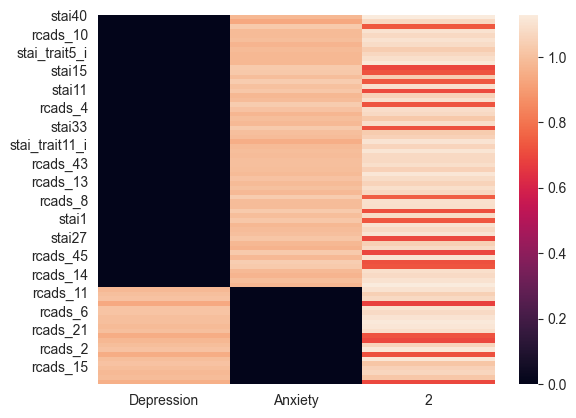

In [64]:
sns.heatmap(load_df.T)

In [65]:
banda_data = pd.concat([banda_df_scored[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(banda_model.fit_transform(banda_scaled[banda_columns].values)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Internalizing"})], axis=1)

In [68]:
banda_data.groupby("phenotype").mean(numeric_only=True)

,interview_age,Anxiety,Depression,Internalizing
phenotype,,,,
Anxiety,185.922078,0.561729,0.416304,0.494288
Control,182.555556,-2.960452,-3.012849,-3.355176
Depression,186.904762,2.273895,2.504033,2.751046


In [67]:
banda_data['Anxiety'] = banda_data['Anxiety'] * -1
banda_data['Depression'] = banda_data['Depression'] * -1
#banda_data['Internalizing'] = banda_data['Internalizing'] * -1

In [69]:
banda_data[["Anxiety", "Depression", "Internalizing"]].corr()

,Anxiety,Depression,Internalizing
Anxiety,1.000000,0.993652,0.994792
Depression,0.993652,1.000000,0.995292
Internalizing,0.994792,0.995292,1.000000


<Axes: >

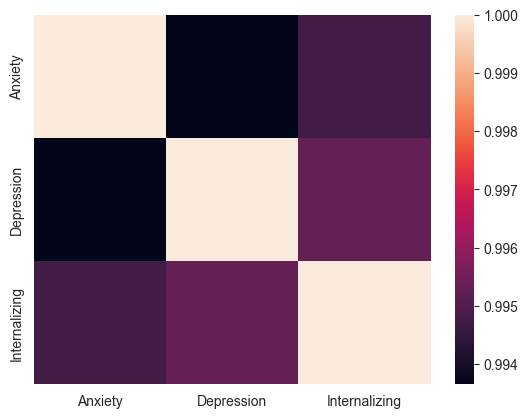

In [70]:
sns.heatmap(banda_data[["Anxiety", "Depression", "Internalizing"]].corr())

In [71]:
combined_df = pd.concat([banda_data, ep_data, pdc_data])

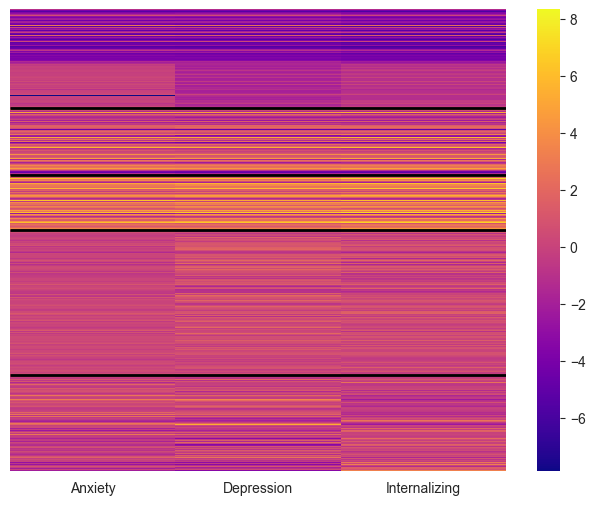

In [72]:
combined_df = pd.concat([banda_data, ep_data, pdc_data])
plotting_banda_data = combined_df.groupby("phenotype")
plotting_banda_data = pd.concat([
    plotting_banda_data.get_group("Control"),
    plotting_banda_data.get_group("Anxiety"),
    plotting_banda_data.get_group("Depression"),
    plotting_banda_data.get_group("T_depression"),
    plotting_banda_data.get_group("early_psychosis")
]).reset_index(drop=True)

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    plotting_banda_data[['Anxiety', 'Depression', 'Internalizing']],
    cmap='plasma',
    ax=ax,
    cbar=True,
    yticklabels=False,
    linecolor='black',
)

# Add lines at group boundaries
group_sizes = [
    len(plotting_banda_data[plotting_banda_data["phenotype"] == "Control"]),
    len(plotting_banda_data[plotting_banda_data["phenotype"] == "Anxiety"]),
    len(plotting_banda_data[plotting_banda_data["phenotype"] == "Depression"]),
    len(plotting_banda_data[plotting_banda_data["phenotype"] == "T_depression"]),
    len(plotting_banda_data[plotting_banda_data["phenotype"] == "early_psychosis"])
]

# Compute cumulative boundaries
boundaries = [sum(group_sizes[:i]) for i in range(1, len(group_sizes))]

for b in boundaries:
    ax.hlines(b, *ax.get_xlim(), colors="black", linewidth=2)
plt
plt.show()

<Axes: >

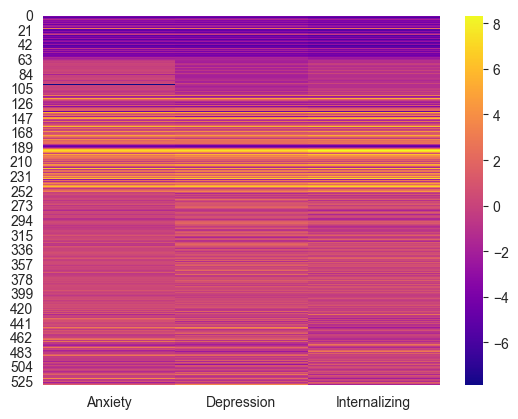

In [73]:
combined_df = pd.concat([banda_data, ep_data, pdc_data])
plotting_banda_data = combined_df.groupby("phenotype")
plotting_banda_data = pd.concat([plotting_banda_data.get_group("Control"), 
                                 plotting_banda_data.get_group("Anxiety"), 
                                 plotting_banda_data.get_group("Depression"), 
                                 plotting_banda_data.get_group("T_depression"),
                                 plotting_banda_data.get_group("early_psychosis")]).reset_index(drop=True)
sns.heatmap(plotting_banda_data[['Anxiety', 'Depression', 'Internalizing']], cmap='plasma')

In [74]:
combined_df.groupby("phenotype")[["Anxiety", "Depression"]].mean()

,Anxiety,Depression
phenotype,,
Anxiety,5.617286e-01,4.163038e-01
Control,-1.785378e+00,-2.338851e+00
Depression,2.273895e+00,2.504033e+00
T_depression,9.180241e-02,4.486791e-01
early_psychosis,-7.601527e-17,-9.601929e-17


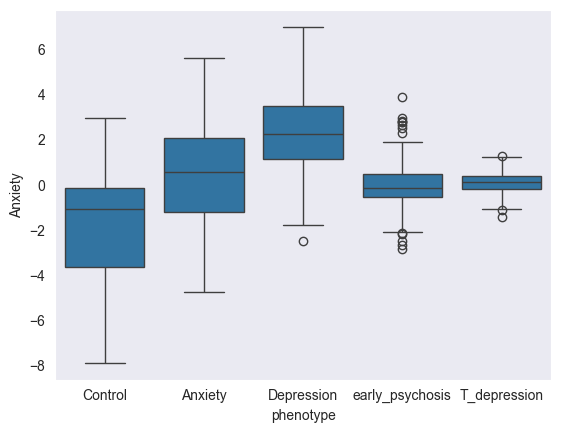

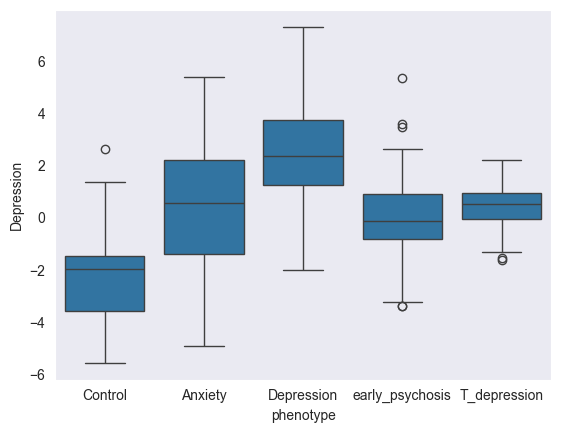

In [75]:
for val in ['Anxiety', 'Depression']:
    plot = sns.boxplot(data=combined_df, x='phenotype', y=val,)
    plt.show()

In [80]:
combined_df.to_csv(os.path.join(config("base_dir"), "behavioural", 'fa_loadings.csv'), index=False)